In [1]:
import os
os.sys.path

['/Users/nirvanabear/Documents/code/MOOCs/Scikit-learn_FUN-MOOC/scikit-learn-mooc/notebooks',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9',
 '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload',
 '',
 '/Users/nirvanabear/.local/share/virtualenvs/scikit-learn-mooc-btn2WeXi/lib/python3.9/site-packages']

Open the dataset bike_rides.csv with the following commands:

In [101]:
import pandas as pd

cycling = pd.read_csv("../datasets/bike_rides.csv", index_col=0,
                      parse_dates=True)
cycling.index.name = ""
target_name = "power"
data, target = cycling.drop(columns=target_name), cycling[target_name]
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


A detailed description of this dataset is given in the appendix. As a reminder, the problem we are trying to solve with this dataset is to use measurements from cheap sensors (GPS, heart-rate monitor, etc.) in order to predict a cyclist power. Power can indeed be recorded via a cycling power meter device, but this device is rather expensive.

Instead of using blindly machine learning, we will first introduce some flavor of classic mechanics: the Newton's second law.

$ P_{meca} = (\frac{1}{2} \rho . SC_x . V_{a}^{2} + C_r . mg . \cos \alpha + mg . \sin \alpha + ma) V_d $ 

where:  
ρ is the air density in $ kg.m^{−3} $,  
S is frontal surface of the cyclist in $ m^{2} $,  
$ C_x $ is the drag coefficient,  
$ V_a $ is the air speed in $ m.s^{−1} $,  
$ C_r $ is the rolling coefficient,  
m is the mass of the rider and bicycle in kg,  
g is the standard acceleration due to gravity which is equal to 9.81 $ m.s^{−2} $,  
α is the slope in radian,  
$ V_d $ is the rider speed in $ m.s^{−1} $, and  
a is the rider acceleration in $ m.s^{−2} $.

This equation might look a bit complex at first but we can explain with words what the different terms within the parenthesis are:

* the first term is the power that a cyclist is required to produce to fight wind
* the second term is the power that a cyclist is required to produce to fight the rolling resistance created by the tires on the floor
* the third term is the power that a cyclist is required to produce to go up a hill if the slope is positive. If the slope is negative the cyclist does not need to produce any power to go forward
* the fourth and last term is the power that a cyclist requires to change his speed (i.e. acceleration).

We can simplify the model above by using the data that we have at hand. It would look like the following.

$ P_{meca}=β_1V^3_d+β_2V_d+β_3sin(α)V_d+β_4aV_d $

This model is closer to what we saw previously: it is a linear model trained on a non-linear feature transformation. We will build, train and evaluate such a model as part of this exercise. Thus, you need to:

* create a new data matrix containing:  
the cube of the speed,  
the speed,  
the speed multiplied by the sine of the angle of the slope, and  
the speed multiplied by the acceleration.  
To compute the angle of the slope, you need to take the arc tangent of the slope (`alpha = np.arctan(slope)`). In addition, we can limit ourself to positive acceleration only by clipping to 0 the negative acceleration values (they would correspond to some power created by the braking that we are not modeling here).
* using the new data matrix, create a linear predictive model based on a `sklearn.preprocessing.StandardScaler` and a `sklearn.linear_model.RidgeCV`;
* use a `sklearn.model_selection.ShuffleSplit` cross-validation strategy with only 4 splits (`n_splits=4`) to evaluate the generalization performance of the model. Use the mean absolute error (MAE) as a generalization performance metric. Also, pass the parameter `return_estimator=True` and `return_train_score=True` to answer the subsequent questions. Be aware that the `ShuffleSplit` strategy is a naive strategy and we will investigate the consequence of making this choice in the subsequent questions.


In [46]:
import numpy as np
data

,heart-rate,cadence,speed,acceleration,slope
,,,,,
2020-08-18 14:43:19,102.0,64.0,4.325,0.0880,-0.033870
2020-08-18 14:43:20,103.0,64.0,4.336,0.0842,-0.033571
2020-08-18 14:43:21,105.0,66.0,4.409,0.0234,-0.033223
2020-08-18 14:43:22,106.0,66.0,4.445,0.0016,-0.032908
2020-08-18 14:43:23,106.0,67.0,4.441,0.1144,0.000000
...,...,...,...,...,...
2020-09-13 14:55:57,130.0,0.0,1.054,0.0234,0.000000
2020-09-13 14:55:58,130.0,0.0,0.829,0.0258,0.000000
2020-09-13 14:55:59,129.0,0.0,0.616,-0.1686,0.000000


In [34]:
speed = data['speed'] 

In [57]:
speed_cube = data['speed'] ** 3


2020-08-18 14:43:19    80.901828
2020-08-18 14:43:20    81.520685
2020-08-18 14:43:21    85.707790
2020-08-18 14:43:22    87.824421
2020-08-18 14:43:23    87.587538
                         ...    
2020-09-13 14:55:57     1.170905
2020-09-13 14:55:58     0.569723
2020-09-13 14:55:59     0.233745
2020-09-13 14:56:00     0.000000
2020-09-13 14:56:01     0.000000
Name: speed, Length: 38254, dtype: float64

In [10]:
np.arctan(data['slope'])


2020-08-18 14:43:19   -0.033857
2020-08-18 14:43:20   -0.033559
2020-08-18 14:43:21   -0.033210
2020-08-18 14:43:22   -0.032896
2020-08-18 14:43:23    0.000000
                         ...   
2020-09-13 14:55:57    0.000000
2020-09-13 14:55:58    0.000000
2020-09-13 14:55:59    0.000000
2020-09-13 14:56:00    0.000000
2020-09-13 14:56:01    0.000000
Name: slope, Length: 38254, dtype: float64

In [28]:
anglex = np.array([])
# angle2 = np.concatenate((angle, [1]))
# angle2
for slope in data['slope']:
    # print(slope)
    arctan_slope = np.arctan(slope)
    anglex = np.append(anglex, arctan_slope)
print(anglex[:10])

[-0.03385666 -0.03355853 -0.03321038 -0.0328964   0.          0.
  0.          0.          0.          0.        ]


In [30]:
alpha = np.arctan(data['slope'])

In [32]:
sin_alpha = np.sin(alpha)
# sin_alpha

In [36]:
speed_sin_a = speed * sin_alpha
# speed_sin_a

In [ ]:
speed_acc = speed * data['acceleration']
# speed_acc

In [56]:
accel = data['acceleration'].copy()
accel[accel < 0] = 0
accel


2020-08-18 14:43:19    0.0880
2020-08-18 14:43:20    0.0842
2020-08-18 14:43:21    0.0234
2020-08-18 14:43:22    0.0016
2020-08-18 14:43:23    0.1144
                        ...  
2020-09-13 14:55:57    0.0234
2020-09-13 14:55:58    0.0258
2020-09-13 14:55:59    0.0000
2020-09-13 14:56:00    0.0000
2020-09-13 14:56:01    0.0000
Name: acceleration, Length: 38254, dtype: float64

In [70]:
accel2 = data['acceleration'].copy()
# accel2= pd.DataFrame(accel2)
accel2.clip(lower=0)


2020-08-18 14:43:19    0.0880
2020-08-18 14:43:20    0.0842
2020-08-18 14:43:21    0.0234
2020-08-18 14:43:22    0.0016
2020-08-18 14:43:23    0.1144
                        ...  
2020-09-13 14:55:57    0.0234
2020-09-13 14:55:58    0.0258
2020-09-13 14:55:59    0.0000
2020-09-13 14:56:00    0.0000
2020-09-13 14:56:01    0.0000
Name: acceleration, Length: 38254, dtype: float64

In [54]:
data['acceleration']


2020-08-18 14:43:19    0.0880
2020-08-18 14:43:20    0.0842
2020-08-18 14:43:21    0.0234
2020-08-18 14:43:22    0.0016
2020-08-18 14:43:23    0.1144
                        ...  
2020-09-13 14:55:57    0.0234
2020-09-13 14:55:58    0.0258
2020-09-13 14:55:59   -0.1686
2020-09-13 14:56:00   -0.4284
2020-09-13 14:56:01   -0.3096
Name: acceleration, Length: 38254, dtype: float64

In [58]:
speed_accel = speed * accel

In [59]:
data2 = pd.DataFrame({'speed cubed': speed_cube, 'speed': speed, 'speed * slope': speed_sin_a, 'speed * accel': speed_accel})

In [60]:
data2

,speed cubed,speed,speed * slope,speed * accel
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.380600
2020-08-18 14:43:20,81.520685,4.336,-0.145482,0.365091
2020-08-18 14:43:21,85.707790,4.409,-0.146398,0.103171
2020-08-18 14:43:22,87.824421,4.445,-0.146198,0.007112
2020-08-18 14:43:23,87.587538,4.441,0.000000,0.508050
...,...,...,...,...
2020-09-13 14:55:57,1.170905,1.054,0.000000,0.024664
2020-09-13 14:55:58,0.569723,0.829,0.000000,0.021388
2020-09-13 14:55:59,0.233745,0.616,0.000000,0.000000


In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit, cross_validate

shuffle = ShuffleSplit(n_splits=4)
model_ridge = make_pipeline(StandardScaler(), RidgeCV())
cv_ridge = cross_validate(model_ridge, data2, target, cv=shuffle, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')

<h1>Question 1</h1> (1/1 point)

What is the mean value of the column containing the information of sin(α)Vd?
a) about -3
b) about -0.3
c) about -0.03
d) about -0.003 

In [65]:
data2['speed * slope'].mean()

-0.002709709612566326

<h1>Question 2</h1> (1 point possible)

On average, the Mean Absolute Error on the test sets obtained through cross-validation is closest to:
a) 20 Watts
b) 50 Watts
c) 70 Watts
d) 90 Watts 

In [66]:
-cv_ridge['test_score'].mean()

72.25771931277096

<h1>Question 3</h1> (1 point possible)

Given the model Pmeca=β1V3d+β2Vd+β3sin(α)Vd+β4aVd that you created, inspect the weights of the linear models fitted during cross-validation and select the correct statements:
a) β1<β2<β3
b) β3<β1<β2
c) β2<β3<β1
d) β1<0
e) β2<0
f) β3<0
g) β4<0
h) All βs are > 0 

In [82]:
coefs = [est[-1].coef_ for est in cv_ridge["estimator"]]
coefs

[array([ 5.95628081, 32.40979238, 80.48855519, 11.1159828 ]),
 array([ 5.69342237, 32.83262422, 80.82814369, 11.06143925]),
 array([ 4.9136873 , 33.56976249, 80.68236154, 11.18276228]),
 array([ 5.50021407, 33.18447618, 80.68100628, 11.11275065])]

In [81]:
for model in cv_ridge['estimator']:
    print(model.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'ridgecv', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'ridgecv__alpha_per_target', 'ridgecv__alphas', 'ridgecv__cv', 'ridgecv__fit_intercept', 'ridgecv__gcv_mode', 'ridgecv__normalize', 'ridgecv__scoring', 'ridgecv__store_cv_values'])
dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'ridgecv', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'ridgecv__alpha_per_target', 'ridgecv__alphas', 'ridgecv__cv', 'ridgecv__fit_intercept', 'ridgecv__gcv_mode', 'ridgecv__normalize', 'ridgecv__scoring', 'ridgecv__store_cv_values'])
dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'ridgecv', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'ridgecv__alpha_per_target', 'ridgecv__alphas', 'ridgecv__cv', 'ridgecv__fit_intercept', 'ridgecv__gcv_mode', 'ridgecv__normalize', 'ridgecv__scoring', 'ridgecv__store_cv_values'])
dict

In [83]:
coefs[0]

array([ 5.95628081, 32.40979238, 80.48855519, 11.1159828 ])

In [87]:
data2[:1]

,speed cubed,speed,speed * slope,speed * accel
,,,,
2020-08-18 14:43:19,80.901828,4.325,-0.146402,0.3806


In [88]:
data2[:1].to_numpy()

array([[80.90182813,  4.325     , -0.14640208,  0.3806    ]])

In [90]:
np.sum(coefs[0] * data2[:1].to_numpy())

614.4934092307025

In [91]:
target[0]

150.0

 <h1>Question 4</h1> (1 point possible)

Now, we will create a predictive model that uses all data, including available sensor measurements such as cadence (the speed at which a cyclist turns pedals measured in rotation per minute) and heart-rate (the number of beat per minute of the heart of the cyclist while exercising). Also, we will use a non-linear regressor, a sklearn.ensemble.HistGradientBoostingRegressor. Fix the number of maximum iterations to 1000 (max_iter=1_000) and activate the early stopping (early_stopping=True). Repeat the previous evaluation using this regressor.

On average, the Mean Absolute Error on the test sets obtained through cross-validation is closest to:
a) 20 Watts
b) 40 Watts
c) 60 Watts
d) 80 Watts 

In [102]:
from sklearn.ensemble import HistGradientBoostingRegressor

model_histo = make_pipeline(StandardScaler(), HistGradientBoostingRegressor(max_iter=1000, early_stopping=True))
cv_histo = cross_validate(model_histo, data, target, cv=shuffle, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')

In [103]:
f"{-cv_histo['test_score'].mean():.3f}"

'44.502'

 <h1>Question 5</h1> (1 point possible)

Comparing both the linear model and the histogram gradient boosting model and taking into consideration the train and test MAE obtained via cross-validation, select the correct statements:
a) the generalization performance of the histogram gradient-boosting model is limited by its underfitting
b) the generalization performance of the histogram gradient-boosting model is limited by its overfitting
c) the generalization performance of the linear model is limited by its underfitting
d) the generalization performance of the linear model is limited by its overfitting  

Select all answers that apply

Hint: look at the values of the train_score and the test_score collected in the dictionaries returned by the cross_validate function.

In [105]:
print(f"Linear train: {-cv_ridge['train_score'].mean():.3f}")
print(f"Linear test: {-cv_ridge['test_score'].mean():.3f}")
print(f"Histogram train: {-cv_histo['train_score'].mean():.3f}")
print(f"Histogram test: {-cv_histo['test_score'].mean():.3f}")

Linear train: 72.486
Linear test: 72.258
Histogram train: 40.984
Histogram test: 44.502


 <h1>Question 6</h1> (1 point possible)

In the previous cross-validation, we made the choice of using a ShuffleSplit cross-validation strategy. It means that randomly selected samples were selected as testing set ignoring any time dependency between the lines of the dataframe.

We would like to have a cross-validation strategy that evaluates the capacity of our model to predict on a completely new bike ride: the samples in the validation set should only come from rides not present in the training set.

How many bike rides are stored in the dataframe data? Do not hesitate to look at the hints.
a) 2
b) 3
c) 4
d) 5


Hint 1: You can check the unique day in the DatetimeIndex (the index of the dataframe data). Indeed, we assume that on a given day the rider went cycling at most once per day.

Hint 2: You can access to the date and time of a DatetimeIndex using df.index.date and df.index.time, respectively.

In [134]:
np.unique(data.index.date).size

4

In [132]:
data.index.values

array(['2020-08-18T14:43:19.000000000', '2020-08-18T14:43:20.000000000',
       '2020-08-18T14:43:21.000000000', ...,
       '2020-09-13T14:55:59.000000000', '2020-09-13T14:56:00.000000000',
       '2020-09-13T14:56:01.000000000'], dtype='datetime64[ns]')

 <h1>Question 7</h1> (1 point possible)

Instead of using the naive `ShuffleSplit` strategy, we will use a strategy that takes into account the group defined by each individual date. It corresponds to a bike ride. We would like to have a cross-validation strategy that evaluates the capacity of our model to predict on a completely new bike ride: the samples in the validation set should only come from rides not present in the training set. Therefore, we can use a `LeaveOneGroupOut` strategy: at each iteration of the cross-validation, we will keep a bike ride for the evaluation and use all other bike rides to train our model.

Thus, you concretely need to:

* create a variable called `group` that is a 1D numpy array containing the index of each ride present in the dataframe. Therefore, the length of `group` will be equal to the number of samples in `data`. If we had 2 bike rides, we would expect the indices 0 and 1 in `group` to differentiate the bike ride. You can use `pd.factorize` to encode any Python types into integer indices.
* create a cross-validation object named cv using the `sklearn.model_selection.LeaveOneGroupOut` strategy.
* evaluate both the linear and histogram gradient boosting models with this strategy.

Using the previous evaluations (with the `LeaveOneGroupOut` strategy) and looking at the train and test errors for both models, select the correct statements:
a) the generalization performance of the gradient-boosting model is limited by its underfitting
b) the generalization performance of the gradient-boosting model is limited by its overfitting
c) the generalization performance of the linear model is limited by its underfitting
d) the generalization performance of the linear model is limited by its overfitting
- unanswered


In [143]:
unique_dates2 = np.unique(data.index.date)
unique_dates2

array([datetime.date(2020, 8, 18), datetime.date(2020, 8, 20),
       datetime.date(2020, 8, 26), datetime.date(2020, 9, 13)],
      dtype=object)

In [147]:
group, unique_dates = pd.factorize(data.index.date)

In [148]:
print(group.size)
print(data.shape)
print(data2.shape)

38254
(38254, 5)
(38254, 4)


In [145]:
unique_dates == unique_dates2

array([ True,  True,  True,  True])

In [163]:
from sklearn.model_selection import LeaveOneGroupOut

leave_one = LeaveOneGroupOut()

In [164]:
cv_ridge2 = cross_validate(model_ridge, data2, target, cv=leave_one, groups=group, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')

In [165]:
cv_histo2 = cross_validate(model_histo, data, target, cv=leave_one, groups=group, return_estimator=True, return_train_score=True, scoring='neg_mean_absolute_error')

In [166]:
print(f"Linear train: {-cv_ridge2['train_score'].mean():.3f}")
print(f"Linear test: {-cv_ridge2['test_score'].mean():.3f}")
print(f"Histogram train: {-cv_histo2['train_score'].mean():.3f}")
print(f"Histogram test: {-cv_histo2['test_score'].mean():.3f}")

Linear train: 72.249
Linear test: 73.015
Histogram train: 39.070
Histogram test: 49.768


 <h1>Question 8</h1> (1 point possible)

In this case we cannot compare cross-validation scores fold-to-fold as the folds are not aligned (they are not generated by the exact same strategy). Instead, compare the mean of the cross-validation test errors in the evaluations of the linear model to select the correct statement.

When using the ShuffleSplit strategy, the mean test error:
a) is greater than the LeaveOneGroupOut mean test error by more than 3 Watts, i.e. ShuffleSplit is giving over-pessimistic results
b) differs from the LeaveOneGroupOut mean test error by less than 3 Watts, i.e. both cross-validation strategies are equivalent
c) is lower than the LeaveOneGroupOut mean test error by more than 3 Watts, i.e. ShuffleSplit is giving over-optimistic results 

In [169]:
print(f"Linear Shuffle: {-cv_ridge['test_score'].mean():.3f} +/- {cv_ridge['test_score'].std():.3f}")
print(f"Linear Leave One: {-cv_ridge2['test_score'].mean():.3f} +/- {cv_ridge2['test_score'].std():.3f}")

Linear Shuffle: 72.258 +/- 1.095
Linear Leave One: 73.015 +/- 5.779


 <h1>Question 9</h1> (1 point possible)

Compare the mean of the cross-validation test errors in the evaluations of the gradient-boosting model to select the correct statement.

When using the ShuffleSplit strategy, the mean test error:
a) is greater than the LeaveOneGroupOut mean test error by more than 3 Watts, i.e. ShuffleSplit is giving over-pessimistic results
b) differs from the LeaveOneGroupOut mean test error by less than 3 Watts, i.e. both cross-validation strategies are equivalent
c) is lower than the LeaveOneGroupOut mean test error by more than 3 Watts, i.e. ShuffleSplit is giving over-optimistic results 

In [170]:
print(f"Histogram Shuffle: {-cv_histo['test_score'].mean():.3f} +/- {cv_histo['test_score'].std():.3f}")
print(f"Histogram Leave One: {-cv_histo2['test_score'].mean():.3f} +/- {cv_histo2['test_score'].std():.3f}")

Histogram Shuffle: 44.502 +/- 0.460
Histogram Leave One: 49.768 +/- 2.513


 <h1>Question 10</h1> (1 point possible)

Compare more precisely the errors estimated through cross-validation and select the correct statement:
a) in general, the standard deviation of the train and test errors increased using the LeaveOneGroupOut cross-validation
b) in general, the standard deviation of the train and test errors decreased using the LeaveOneGroupOut cross-validation

 <h1>Question 10</h1> (1 point possible)

Now, we will go more into details by picking a single ride for the testing and analyse the predictions of the models for this test ride. To do so, we can reuse the LeaveOneGroupOut cross-validation object in the following manner:

In [180]:
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([1, 2, 1, 2])
groups = np.array([1, 1, 2, 2])
logo = LeaveOneGroupOut()

# Returns all possible permutations of training and testing splits.
for train_index, test_index in logo.split(X, y, groups):
    print(train_index, test_index)

[2 3] [0 1]
[0 1] [2 3]


In [179]:
list(cv.split(data, target, groups=group))[0]

(array([10222, 10223, 10224, ..., 38251, 38252, 38253]),
 array([    0,     1,     2, ..., 10219, 10220, 10221]))

In [182]:
cv = LeaveOneGroupOut()
train_indices, test_indices = list(cv.split(data, target, groups=group))[0]

data2_train = data2.iloc[train_indices]
data2_test = data2.iloc[test_indices]

data_train = data.iloc[train_indices]
data_test = data.iloc[test_indices]

target_train = target.iloc[train_indices]
target_test = target.iloc[test_indices]

Now, fit both the linear model and the histogram gradient boosting regressor models on the training data and collect the predictions on the testing data. Make a scatter plot where on the x-axis, you will plot the measured powers (true target) and on the y-axis, you will plot the predicted powers (predicted target). Do two separated plots for each model.

By analysing the plots, select the correct statements:
a) the linear regressor tends to under-predict samples with high power
b) the linear regressor tends to over-predict samples with high power
c) the linear regressor makes catastrophic predictions for samples with power close to zero
d) the histogram gradient boosting regressor tends to under-predict samples with high power
e) the histogram gradient boosting regressor tends to over-predict samples with high power
f) the histogram gradient boosting makes catastrophic predictions for samples with power close to zero



In [184]:
import seaborn as sns
import matplotlib.pyplot as plt

model_ridge.fit(data2_train, target_train)
model_histo.fit(data_train, target_train)
predict_ridge = model_ridge.predict(data2_test)
predict_histo = model_histo.predict(data_test)

true_v_predict_ridge = pd.DataFrame({"measured_power": target_test, "predicted_power": predict_ridge})
true_v_predict_histo = pd.DataFrame({"measured_power": target_test, "predicted_power": predict_histo})

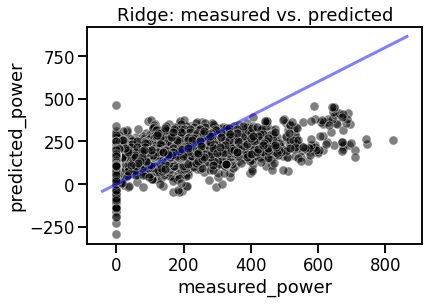

In [186]:
ax2 = sns.scatterplot(data=true_v_predict_ridge, x="measured_power", y="predicted_power",
                     color="black", alpha=0.5)

xpoints = ypoints = plt.xlim()
ax2.plot(xpoints, ypoints, color="blue", lw=3, alpha=.5)
_ = ax2.set_title(f"Ridge: measured vs. predicted")

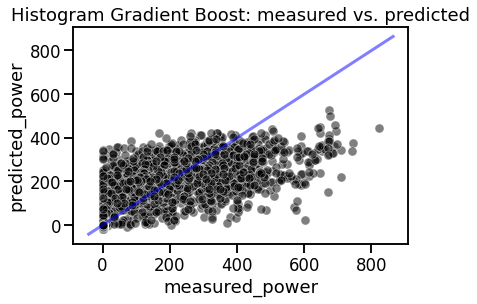

In [188]:

ax = sns.scatterplot(data=true_v_predict_histo, x="measured_power", y="predicted_power",
                     color="black", alpha=0.5)
# ax2.plot(data, pre)
xpoints = ypoints = plt.xlim()
ax.plot(xpoints, ypoints, color="blue", lw=3, alpha=.5)
_ = ax.set_title(f"Histogram Gradient Boost: measured vs. predicted")

 <h1>Question 11</h1> (1 point possible)

Now select a portion of the testing data using the following code:

In [191]:
time_slice = slice("2020-08-18 17:00:00", "2020-08-18 17:05:00")

data2_test_subset = data2_test[time_slice]
data_test_subset = data_test[time_slice]
target_test_subset = target_test[time_slice]

It allows to select data from 5.00 pm until 5.05 pm. Used the previous fitted models (linear and gradient-boosting regressor) to predict on this portion of the test data. Draw on the same plot the true targets and the predictions of each model.

By using the previous plot, select the correct statements:
a) the linear model is more accurate than the histogram gradient boosting regressor
b) the histogram gradient boosting regressor is more accurate than the linear model 

In [192]:
predict_ridge_slice = model_ridge.predict(data2_test_subset)
predict_histo_slice = model_histo.predict(data_test_subset)

true_v_predict_ridge_slice = pd.DataFrame({"measured_power": target_test_subset, "predicted_power": predict_ridge_slice})
true_v_predict_histo_slice = pd.DataFrame({"measured_power": target_test_subset, "predicted_power": predict_histo_slice})

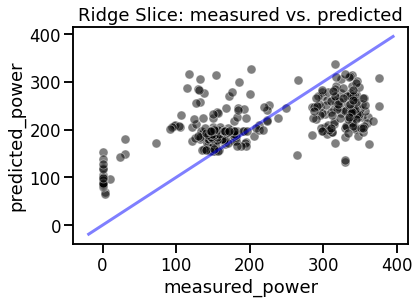

In [193]:
ax4 = sns.scatterplot(data=true_v_predict_ridge_slice, x="measured_power", y="predicted_power",
                     color="black", alpha=0.5)

xpoints = ypoints = plt.xlim()
ax4.plot(xpoints, ypoints, color="blue", lw=3, alpha=.5)
_ = ax4.set_title(f"Ridge Slice: measured vs. predicted")

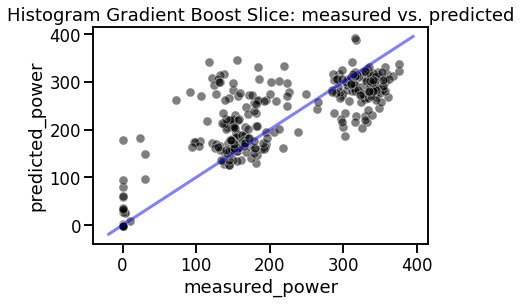

In [194]:
ax3 = sns.scatterplot(data=true_v_predict_histo_slice, x="measured_power", y="predicted_power",
                     color="black", alpha=0.5)

xpoints = ypoints = plt.xlim()
ax3.plot(xpoints, ypoints, color="blue", lw=3, alpha=.5)
_ = ax3.set_title(f"Histogram Gradient Boost Slice: measured vs. predicted")

In [195]:
score_ridge_slice = model_ridge.score(data2_test_subset, target_test_subset)
score_histo_slice = model_histo.score(data_test_subset, target_test_subset)
print(score_ridge_slice)
print(score_histo_slice)

0.381607142529375
0.5847584491224558
